In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

pred_k_t = pred['k_t'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

In [5]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()
k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

In [6]:
occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])
k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

In [7]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

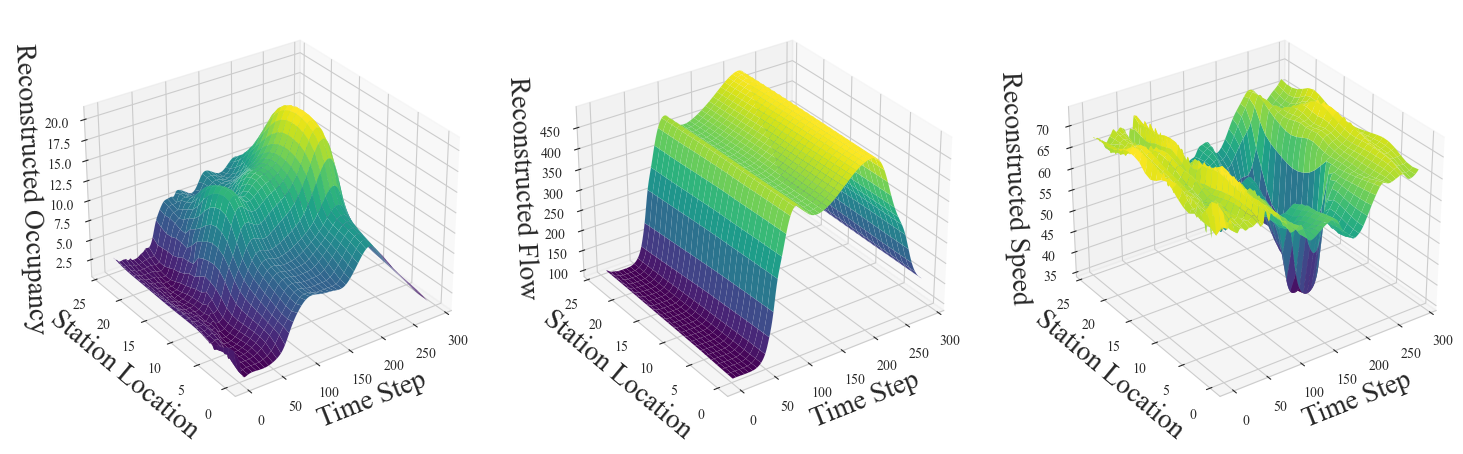

In [8]:
fig = plt.figure(figsize=(18, 9))
plt.rcParams['font.family'] = 'Times New Roman'

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_values, cmap='viridis',linewidth=0.02, antialiased=True)

ax1.view_init(elev=30, azim=235)
ax1.set_xlabel('Time Step', fontsize = 20)
ax1.set_ylabel('Station Location', fontsize = 20)
ax1.set_zlabel('Reconstructed Occupancy', fontsize = 20)
#ax1.set_title('Occupancy Reconstruction', fontsize = 16)


loc, time = flow_recon_wide.index.values, flow_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
flow_values = flow_recon_wide.values.T

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(time, loc, flow_values, cmap='viridis',linewidth=0.02, antialiased=True)

ax2.view_init(elev=30, azim=235)
ax2.set_xlabel('Time Step', fontsize = 20)
ax2.set_ylabel('Station Location', fontsize = 20)
ax2.set_zlabel('Reconstructed Flow', fontsize = 20)
#ax2.set_title('Flow Reconstruction', fontsize = 16)


loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(time, loc, speed_values, cmap='viridis',linewidth=0.02, antialiased=True)

ax3.view_init(elev=30, azim=235)
ax3.set_xlabel('Time Step', fontsize = 20)
ax3.set_ylabel('Station Location', fontsize = 20)
ax3.set_zlabel('Reconstructed Speed', fontsize = 20)
#ax3.set_title('Speed Reconstruction', fontsize = 16)
#plt.tight_layout()
plt.show()
fig.savefig("Figures/Reconstruction_3D.png", dpi = 300)

In [9]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

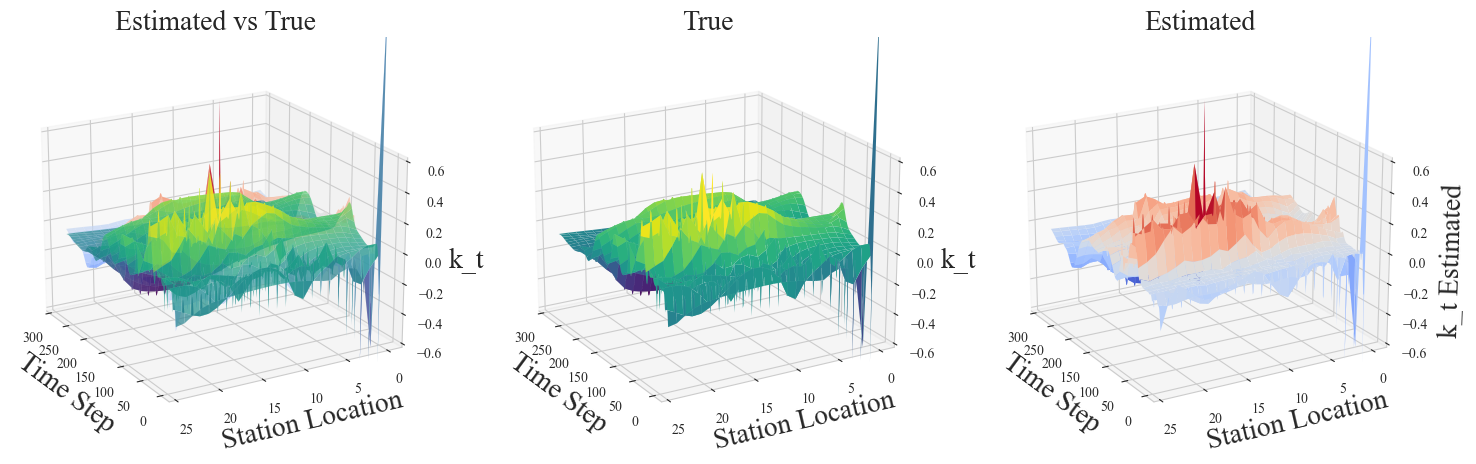

In [14]:
fig = plt.figure(figsize=(18, 9))
plt.rcParams['font.family'] = 'Times New Roman'

loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

ax1 = fig.add_subplot(131, projection='3d')

surf2 = ax1.plot_surface(time, loc, kt_predict_values, cmap=cm.coolwarm,linewidth=0.02, alpha = 0.7, antialiased=True)
surf1 = ax1.plot_surface(time, loc, kt_values, cmap='viridis', linewidth=0.02, alpha = 0.7, antialiased=True)
ax1.view_init(elev=20, azim=150)
ax1.set_xlabel('Time Step', fontsize = 20)
ax1.set_ylabel('Station Location', fontsize = 20)
ax1.set_zlabel('k_t', fontsize = 20)
ax1.set_zlim(-0.6, 0.6)
ax1.set_title('Estimated vs True', fontsize = 20)


# loc, time = k_t_predict_wide.index.values, k_t_predict_wide.columns.astype(int).values
# loc, time = np.meshgrid(loc, time)
# kt_predict_values = k_t_predict_wide.values.T

ax2 = fig.add_subplot(132, projection='3d')
surf3 = ax2.plot_surface(time, loc, kt_values, cmap='viridis', linewidth=0.02, antialiased=True)

ax2.view_init(elev=20, azim=150)
ax2.set_xlabel('Time Step', fontsize = 20)
ax2.set_ylabel('Station Location', fontsize = 20)
ax2.set_zlabel('k_t', fontsize = 20)
ax2.set_title('True', fontsize = 20)
ax2.set_zlim(-0.6, 0.6)

ax3 = fig.add_subplot(133, projection='3d')
surf4 = ax3.plot_surface(time, loc, kt_predict_values, cmap=cm.coolwarm, linewidth=0.02, antialiased=True)

ax3.view_init(elev=20, azim=150)
ax3.set_xlabel('Time Step', fontsize = 20)
ax3.set_ylabel('Station Location', fontsize = 20)
ax3.set_zlabel('k_t Estimated', fontsize = 20)
ax3.set_title('Estimated', fontsize = 20)
ax3.set_zlim(-0.6, 0.6)
#plt.tight_layout()
plt.show()
fig.savefig("Figures/k_t_3D.png", dpi = 300)

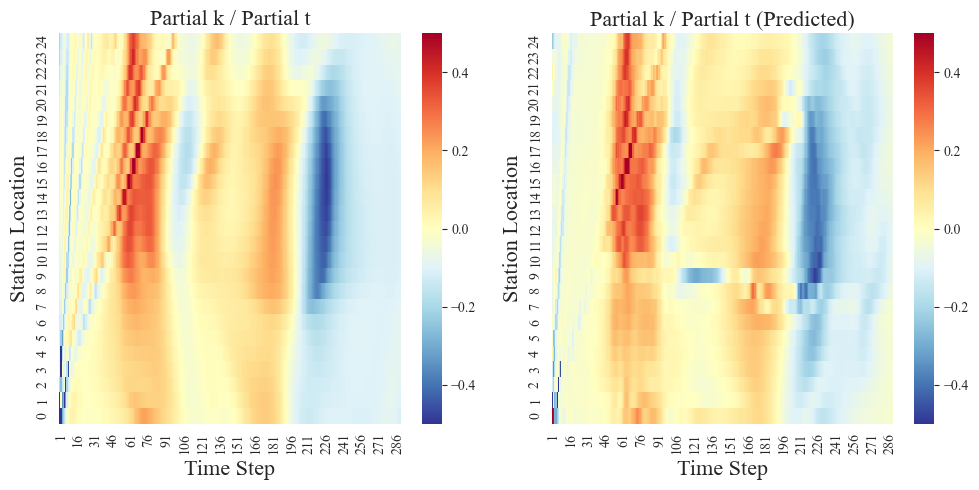

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

vmin, vmax = -0.5, 0.5
sns.heatmap(k_t_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location',  fontsize = 16)
axs[0].set_xlabel('Time Step',  fontsize = 16)
axs[0].set_title("Partial k / Partial t",  fontsize = 16)

sns.heatmap(k_t_predict_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin, vmax=vmax, annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location',  fontsize = 16)
axs[1].set_xlabel('Time Step',  fontsize = 16)
axs[1].set_title("Partial k / Partial t (Predicted)",  fontsize = 16)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures/k_dev.png", dpi = 300)